In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import precision_recall_curve, auc, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from xgboost import XGBClassifier

In [44]:
full_train_df = pd.read_csv('obs_train.csv')

full_train_df.fillna(0, inplace=True)
print(full_train_df.shape)
full_train_df.info(verbose=True)

(331637, 263)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331637 entries, 0 to 331636
Data columns (total 263 columns):
 #    Column                                                    Dtype  
---   ------                                                    -----  
 0    person_id                                                 int64  
 1    SepsisLabel                                               int64  
 2    datetime                                                  object 
 3    datetime_year                                             int64  
 4    datetime_month                                            int64  
 5    datetime_day                                              int64  
 6    datetime_hour                                             int64  
 7    datetime_weekday                                          int64  
 8    MALE                                                      float64
 9    age_in_months                                             float64
 10   hour

In [41]:
def train_model(training_df):
    for state in range(5):
        sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=state)
    
        training_aucs = []
        testing_aucs = []
        testing_accuracy = []
    
        for train_idx, test_idx in sgkf.split(training_df, training_df['SepsisLabel'], groups=training_df['person_id']):
            train_df = training_df.iloc[train_idx].copy()
            test_df = training_df.iloc[test_idx].copy()
    
            train_df.drop(columns=['person_id', 'datetime'], inplace=True)
            test_df.drop(columns=['person_id', 'datetime'], inplace=True)
    
            train_y = train_df['SepsisLabel']
            train_X = train_df.drop(columns='SepsisLabel')
            test_y = test_df['SepsisLabel']
            test_X = test_df.drop(columns='SepsisLabel')
    
            mmx = MinMaxScaler()
            train_X = mmx.fit_transform(train_X)
            test_X = mmx.transform(test_X)
    
            clf = XGBClassifier(
                colsample_bytree = 0.7501745945565902,
                gamma = 0.39428938023558957,
                learning_rate = 0.03908010701819611,
                max_depth = 4,
                min_child_weight = 4.8769931443216805,
                n_estimators = 300,
                reg_alpha = 0.21536773880455967,
                reg_lambda = 0.15388032812481203,
                subsample = 0.7923260274694592,
                objective='binary:logistic',
                eval_metric='aucpr',
                random_state=42,
            )
    
            clf.fit(train_X, train_y)
    
            test_proba_y = clf.predict_proba(test_X)[:, 1]
            train_proba_y = clf.predict_proba(train_X)[:, 1]
    
            test_prec, test_recall, _ = precision_recall_curve(test_y, test_proba_y)
            test_auc = auc(test_recall, test_prec)
    
            train_prec, train_recall, _ = precision_recall_curve(train_y, train_proba_y)
            train_auc = auc(train_recall, train_prec)
    
            testing_aucs.append((test_auc, test_prec, test_recall))
            training_aucs.append((train_auc, train_prec, train_recall))

            test_y_pred = test_proba_y > .5
            accuracy = accuracy_score(test_y, test_y_pred)
            testing_accuracy.append(accuracy)
    
        print(f'--------State {state + 1} of 5----------\
              \nTraining average auc: {np.mean([x[0] for x in training_aucs])}\
              \nTesting average auc: {np.mean([x[0] for x in testing_aucs])}\
              \nTesting average accuracy {np.mean(testing_accuracy)}\n\n')
        
        for fold in range(5):
            plt.plot(testing_aucs[fold][2], testing_aucs[fold][1], 'r')
            plt.plot(training_aucs[fold][2], training_aucs[fold][1], 'b')
        plt.xlabel('recall')
        plt.ylabel('precision')
        plt.show()

--------State 1 of 5----------              
Training average auc: 0.9140611759596698              
Testing average auc: 0.4981815992801354              
Testing average accuracy 0.9807327817855379




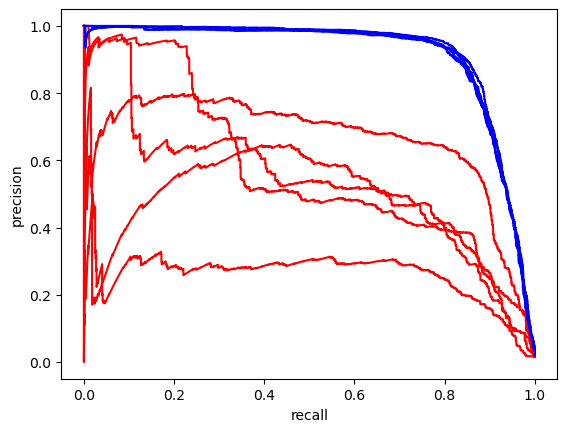

--------State 2 of 5----------              
Training average auc: 0.9129526203711936              
Testing average auc: 0.5150117698664549              
Testing average accuracy 0.9826160357867749




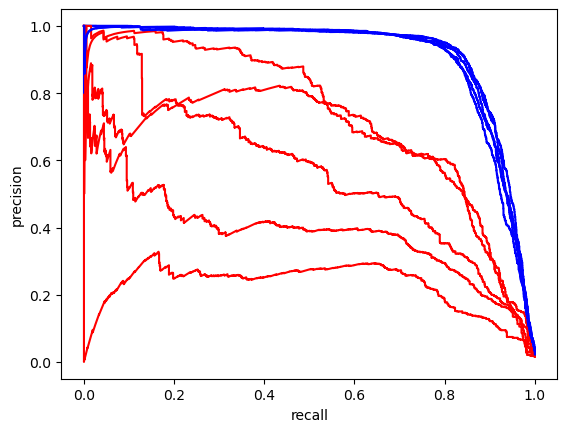

--------State 3 of 5----------              
Training average auc: 0.9135270255802965              
Testing average auc: 0.49038310011881947              
Testing average accuracy 0.9824820472328014




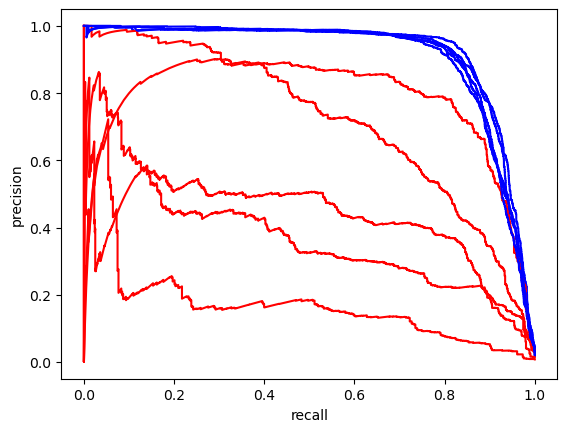

--------State 4 of 5----------              
Training average auc: 0.9138002942065869              
Testing average auc: 0.5241952321936653              
Testing average accuracy 0.9817449717252581




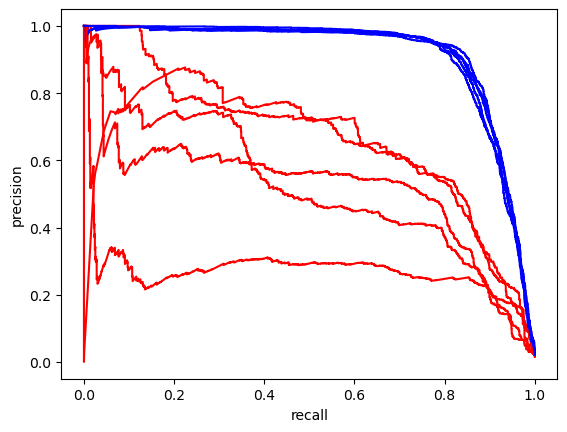

--------State 5 of 5----------              
Training average auc: 0.9130842993929106              
Testing average auc: 0.5086472031375212              
Testing average accuracy 0.9831078416027964




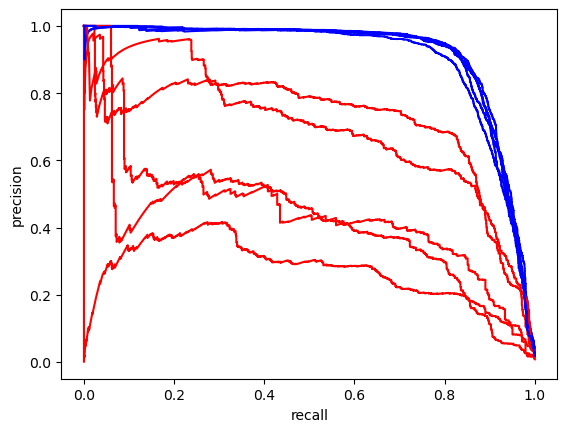

In [42]:
train_model(training_df=full_train_df)